 <img src="res/itm_logo.jpg" width="300px">

## Inteligencia Artificial - IAI84
### Instituto Tecnológico Metropolitano
#### Pedro Atencio Ortiz - 2017


En este notebook se abordan algunas prácticas para mejorar el desempeño de una red neuronal:
1. Inicialización de parámetros
2. Normalización de la entrada
3. Regularización

<hr>
# Caos 1: El problema XOR

<img src='res/shallow_nn/xor_problem.png'>

In [23]:
import numpy as np

Debido a que ahora utilizamos una version traspuesta de los pesos de la red $W$, nuestra activation lineal cambia a $z = WX + b$

In [462]:
def linear_activation(W, b, X):
    z = np.dot(W, X) + b
    
    return z

In [463]:
def sigmoid(z):
    '''
    Returns sigmoid activation for array z
    '''
    a = 1. / (1. + np.exp(-z)) 
    
    return a 

La derivada de la funcion sigmoide, definida como $\sigma'(z) = \sigma(z)*(1-\sigma(z))$

In [464]:
def d_sigmoid(z):
    return sigmoid(z) * (1. - sigmoid(z))

In [465]:
def loss(y, a):
    return -(y * np.log(a) + (1.-y) * np.log(1-a))

In [466]:
def cost(logloss):
    return np.mean(logloss)

In [467]:
def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    Z1 = linear_activation(W1,b1,X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,A1)
    A2 = sigmoid(Z2)

    return np.round(A2)

<hr>
# Trabajemos
3. Realicemos descenso del gradiente sobre la red neural completa.

### - Dataset XOR

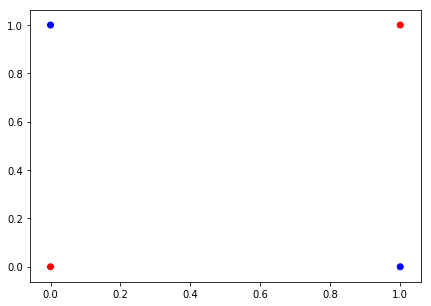

In [468]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0, 1, 1, 0]])

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)

plt.show()

X = X.T

In [469]:
def normalize_input(X):
    v_x = np.var(X)
    m_x = np.mean(X)
    
    X -= m_x
    X /= v_x
    
    return X

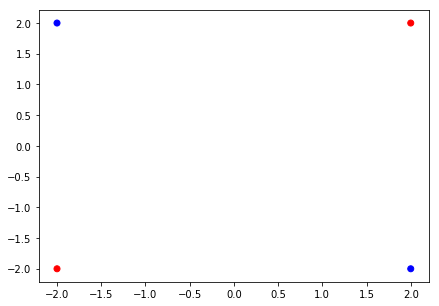

In [470]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
Y = np.array([[0., 1., 1., 0.]])

X = normalize_input(X)

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)

plt.show()

X = X.T

### - Inicializacion de parametros de la red.

In [475]:
def initialize_parameters(neurons_hidden_layer):

    len_X = 2
    
    W1 = np.random.randn(neurons_hidden_layer, len_X) * np.sqrt(2./float(len_X + neurons_hidden_layer))
    b1 = np.zeros([neurons_hidden_layer,1])

    W2 = np.random.randn(1,neurons_hidden_layer) * np.sqrt(2./float(neurons_hidden_layer+1))
    b2 = np.zeros([1,1])
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

<hr>
### - Apliquemos descenso del gradiente a cada regresor logístico por separado

In [484]:
'''
Metaparameters initialization
'''
num_epochs = 10000
learning_rate = 0.01

'''
Parameters initialization
'''
parameters = initialize_parameters(3)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print ("parametros iniciales: ", parameters)

'''
Gradient descent
'''
for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = linear_activation(W1, b1, X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)
        
    '''
    Backward Propagation
    '''
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.mean(np.sum(dZ2, axis=1, keepdims=True))
    dZ1 = np.multiply(np.dot(W2.T, dZ2), d_sigmoid(Z1))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.mean(np.sum(dZ1, axis=1, keepdims=True))
    
    '''
    Parameters Update
    '''
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    
    '''
    Cost estimation
    '''
    J = cost(loss(Y,A2))
    
    
    if(i%1000 == 0):
        print("costo -- iteracion ", i, ": ", J)
        
print("parametros actualizados: ", parameters)

'''
Testing
'''
print("Predicciones del clasificador: ", predict_multilayer(parameters,X))

('parametros iniciales: ', {'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[ 0.2542404 ,  1.19100908],
       [-0.85239767, -0.80352527],
       [ 0.61310031, -0.74194839]]), 'W2': array([[ 1.37434772, -0.29247279, -0.52853037]])})
('costo -- iteracion ', 0, ': ', 0.77143118679784672)
('costo -- iteracion ', 1000, ': ', 0.62333721693785371)
('costo -- iteracion ', 2000, ': ', 0.31472071222075382)
('costo -- iteracion ', 3000, ': ', 0.17031255026203865)
('costo -- iteracion ', 4000, ': ', 0.11377924359850855)
('costo -- iteracion ', 5000, ': ', 0.084854704679320381)
('costo -- iteracion ', 6000, ': ', 0.067461203340784329)
('costo -- iteracion ', 7000, ': ', 0.055899513596310693)
('costo -- iteracion ', 8000, ': ', 0.047677063887797667)
('costo -- iteracion ', 9000, ': ', 0.041538592440225938)
('parametros actualizados: ', {'b2': array([[-4.14327582]]), 'b1': array([[ 3.49186438],
       [ 3.49186438],
       [ 3.49186438]]), 'W1': array([[ 2.557526

In [485]:
import matplotlib.pyplot as plt

def visualize_lr(parameters, X, Y):
    X = X.T
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    #Z = pred_func(W,b,np.c_[xx.ravel(), yy.ravel()])
    Z = predict_multilayer(parameters, np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

### - Visualizacion del resultado

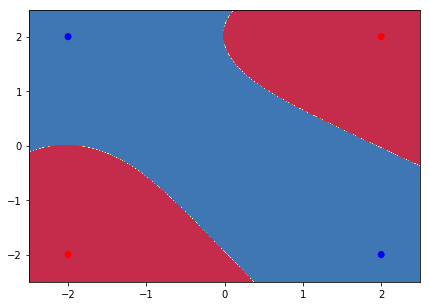

In [486]:
visualize_lr(parameters, X, Y)

<hr>
# Caso 2: Dataset generado

In [516]:
def initialize_parameters_1_layers(neurons_hidden_layer):

    len_X = 2
    
    W1 = np.random.randn(neurons_hidden_layer, 2) / np.sqrt(2. / (len_X + neurons_hidden_layer))
    b1 = np.zeros([neurons_hidden_layer,1])
    
    W2 = np.random.randn(1,neurons_hidden_layer) / np.sqrt(2. / (neurons_hidden_layer + 1) )
    b2 = np.zeros([1,1])
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

In [517]:
def tanh(z):
    return (np.exp(z)- np.exp(-z))/(np.exp(z)+ np.exp(-z))

In [518]:
def d_tanh(z):
    return 1. - tanh(z)**2

In [519]:
def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    Z1 = linear_activation(W1, b1, X)
    A1 = tanh(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)

    return np.round(A2)

In [520]:
from utils import generate_data

X, Y = generate_data('circles')
X = normalize_input(X)

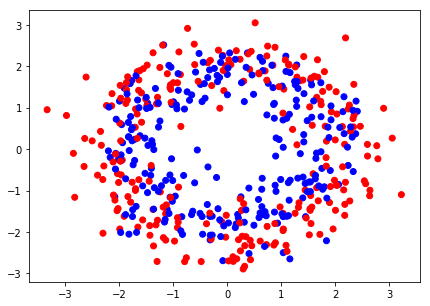

In [521]:
import numpy as np
import matplotlib.pyplot as plt

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)

plt.show()

X = X.T

In [524]:
'''
Metaparameters initialization
'''
num_epochs = 20000
learning_rate = 0.001
reg_param = 0.1

'''
Parameters initialization
'''
parameters = initialize_parameters_1_layers(5)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print ("parametros iniciales: ", parameters)

'''
Gradient descent
'''
for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = linear_activation(W1, b1, X)
    A1 = tanh(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)
        
    '''
    Backward Propagation
    '''
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.mean(np.sum(dZ2, axis=1, keepdims=True))
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), d_tanh(Z1))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.mean(np.sum(dZ1, axis=1, keepdims=True))
    
    dW1 += reg_param * W1
    dW2 += reg_param * W2
    
    '''
    Parameters Update
    '''
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    '''
    Cost estimation
    '''
    J = cost(loss(Y,A2))
    
    
    if(i%1000 == 0):
        print("costo -- iteracion ", i, ": ", J)
        
print("parametros actualizados: ", parameters)

'''
Testing
'''
print("Predicciones del clasificador: ", predict_multilayer(parameters,X))

('parametros iniciales: ', {'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[-2.71105081, -2.46522342],
       [ 1.0121337 , -0.15923671],
       [-1.05571056,  1.80865734],
       [ 0.95050802, -1.41334135],
       [-2.24724227,  0.97893307]]), 'W2': array([[-0.93112171,  0.17182786,  2.73022991,  0.87005803, -1.49349025]])})
('costo -- iteracion ', 0, ': ', 1.0815997163593312)
('costo -- iteracion ', 1000, ': ', 0.60144710105176702)
('costo -- iteracion ', 2000, ': ', 0.59145630921467407)
('costo -- iteracion ', 3000, ': ', 0.58818644922735641)
('costo -- iteracion ', 4000, ': ', 0.58716176672467457)
('costo -- iteracion ', 5000, ': ', 0.58667911908491643)
('costo -- iteracion ', 6000, ': ', 0.58640731788158051)
('costo -- iteracion ', 7000, ': ', 0.58622564502960106)
('costo -- iteracion ', 8000, ': ', 0.58609944472161868)
('costo -- iteracion ', 9000, ': ', 0.58600840813321986)
('costo -- iteracion ', 10000, ': ', 0.5

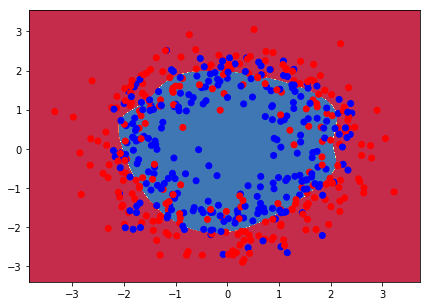

In [525]:
visualize_lr(parameters, X, Y)